# Gold extraction

The data is stored in three files:
gold_recovery_train.csv — training dataset
gold_recovery_test.csv — test dataset
gold_recovery_full.csv — source dataset
Data is indexed with the date and time of acquisition (date feature). Parameters that are next to each other in terms of time are often similar.

Some parameters are not available because they were measured and/or calculated much later. That's why, some of the features that are present in the training set may be absent from the test set. The test set also doesn't contain targets.
The source dataset contains the training and test sets with all the features.

You have the raw data that was only downloaded from the warehouse. Before building the model, check the correctness of the data. For that, use our instructions.
Project instructions

1. Prepare the data
1.1. Open the files and look into the data.
Path to files:
/datasets/gold_recovery_train.csv
/datasets/gold_recovery_test.csv
/datasets/gold_recovery_full.csv
1.2. Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.
1.3. Analyze the features not available in the test set. What are these parameters? What is their type?
1.4. Perform data preprocessing.
2. Analyze the data
2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.
2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.
2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.
3. Build the model
3.1. Write a function to calculate the final sMAPE value.
3.2. Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

##### Goal:

Preparing a machine learning model that predicts the amount of gold recovered from the extraction process for the purpose of optimizing production and eliminating unprofitable parameters.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler


warnings.filterwarnings("ignore", category=RuntimeWarning)

## Part 1: Data preparation

### Open the files and studiyng whats inside

In [6]:
try:
    full = pd.read_csv('gold_industry_full.csv')
    test = pd.read_csv('gold_industry_test.csv')
    train = pd.read_csv('gold_industry_train.csv')
except:
    full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_full.csv')
    test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_test.csv')
    train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_train.csv')

In [7]:
# basic info of ful data
full.info()
full.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686
5,2016-01-15 05:00:00,5.687168,5.801920,1.879351,35.470082,546.173470,57.469578,11.072517,6.200383,999.934134,...,9.302669,41.633678,6.482968,10.049416,5.480257,69.465816,1.918586,10.182708,0.664118,16.999638
6,2016-01-15 06:00:00,6.038436,6.056253,2.105501,34.920570,523.376439,56.674647,11.535899,6.204974,999.832373,...,9.103047,41.995316,6.533849,10.058141,4.569100,69.300835,2.058913,10.304598,0.807342,16.723575
7,2016-01-15 07:00:00,6.433854,5.955053,2.310432,36.091386,549.842749,56.730325,12.557906,6.799275,1000.166602,...,9.369209,42.452727,6.130823,9.935481,4.389813,70.230976,2.143437,10.443288,0.949346,16.689959
8,2016-01-15 08:00:00,6.526612,5.878084,2.391713,35.753879,560.115242,56.649893,13.166128,6.798659,1000.026864,...,9.437044,43.404078,5.834140,10.071156,4.876389,69.688595,2.209881,10.420140,1.065453,17.201948
9,2016-01-15 09:00:00,6.747693,5.974832,2.539114,38.553938,566.616045,60.308763,13.996130,6.800263,1000.332327,...,9.582874,43.487291,5.706261,10.242511,5.214161,70.973641,2.200997,10.473539,1.171183,17.717049


In [8]:
# basic info of test data
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4832 non-null   float64
 4   rougher.input.feed_sol                      4838 non-null   float64
 5   rougher.input.feed_rate                     4856 non-null   float64
 6   rougher.input.feed_size                     4816 non-null   float64
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64
 9   rougher.state.floatbank10_a_air             4859 non-null   float64
 10  rougher.stat

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
1,2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2,2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
3,2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
4,2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805


In [9]:
# basic info of train data
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14572 non-null  float64


,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


In [10]:
# Column date to date type
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
full['date'] = pd.to_datetime(full['date'])

In [11]:
# Column date to index
full.set_index('date', inplace=True)
train.set_index('date', inplace=True)
test.set_index('date', inplace=True)

In [12]:
print('The ratio of the size of the training and the original samples - {:.2f}'.format(len(train) / len(full)))
print('The ratio of the size of the test and the original samples - {:.2f}'.format(len(test) / len(full)))

The ratio of the size of the training and the original samples - 0.75
The ratio of the size of the test and the original samples - 0.25


####  Conclusions on this step
Date column transformed to date type
Date became an index of out data
Train and Test data are: 75 to 25
Technology of the gold extraction:

    rougher:
        rougher.calculation:
            rougher.calculation.sulfate_to_au_concentrate
            rougher.calculation.floatbank10/11_sulfate_to_au_feed
            rougher.calculation.au_pb_ratio
        rougher.input:
            rougher.input.feed_ag/pb/au
            rougher.input.feed_rate
            rougher.input.feed_size
            rougher.input.floatbank10/11_sulfate/xanthate
        rougher.output:
            rougher.output.concentrate_ag/pb/au
            rougher.output.recovery
            rougher.output.tail_ag/pb/au
        rougher.state:
            rougher.state.floatbank10_a/b/c/d/e/f_air
            rougher.state.floatbank10_a/b/c/d/e/f_level
    primary_cleaner:
            primary_cleaner.input:
                primary_cleaner.input.sulfate/depressant/xanthate
                primary_cleaner.input.feed_size
            primary_cleaner.output:
                primary_cleaner.output.concentrate_ag/pb/au
                primary_cleaner.output.tail_ag/pb/au
            primary_cleaner.state:
                primary_cleaner.state.floatbank8_a/b/c/d_air
                primary_cleaner.state.floatbank8_a/b/c/d_level
    secondary_cleaner:
        secondary_cleaner.output:
            secondary_cleaner.output.tail_ag/pb/au
        secondary_cleaner.state
            secondary_cleaner.state.floatbank2/3/4/5/6_a/b_air
            secondary_cleaner.state.floatbank2/3/4/5/6_a/b_level
    final:
        final.output
            final.output.concentrate_ag/pb/au
            final.output.recovery
            final.output.tail_ag/pb/au


In [13]:
C = train['rougher.output.concentrate_au']
F = train['rougher.input.feed_au']
T = train['rougher.output.tail_au']

In [14]:
# Double check rougher.output.recovery by provided formula
train['rougher.output.recovery_test'] = (C * (F - T)) / (F * (C - T)) * 100

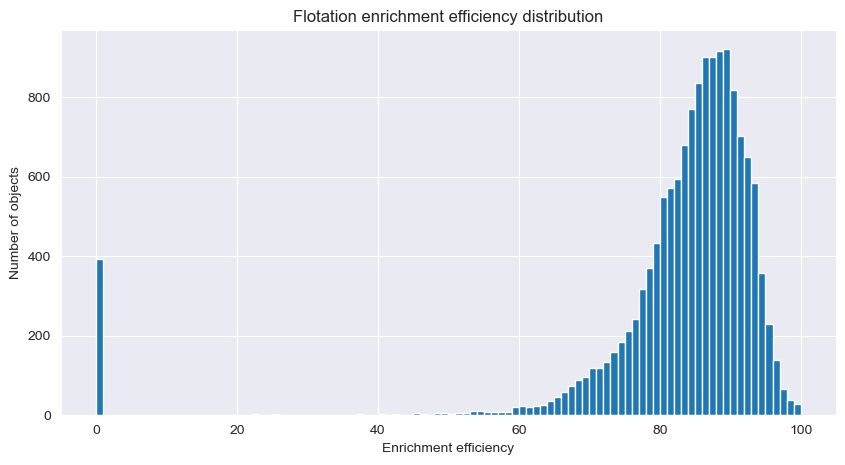

In [15]:
train['rougher.output.recovery_test'].hist(bins=100, figsize=(10, 5))
plt.xlabel('Enrichment efficiency')
plt.ylabel('Number of objects')
plt.title('Flotation enrichment efficiency distribution')
plt.show()

In [16]:
train['rougher.output.recovery_test'].value_counts()

-0.000000     394
 83.406924     10
 91.792293      5
 89.512544      5
 91.636690      4
             ... 
 89.174423      1
 89.329066      1
 90.209377      1
 90.572185      1
 88.890579      1
Name: rougher.output.recovery_test, Length: 14163, dtype: int64

In [17]:
train['rougher.output.recovery'].value_counts()

0.000000     394
83.406924     10
91.792293      5
89.512544      5
91.636690      4
            ... 
89.174423      1
89.329066      1
90.209377      1
90.572185      1
88.890579      1
Name: rougher.output.recovery, Length: 14163, dtype: int64

In [18]:
# Replacement of rougher.output.recovery_test out of [0, 100] range with 0 to replace -0.00000
train.loc[(train['rougher.output.recovery_test'] > 100) | (train['rougher.output.recovery_test'] < 0.0000001), 'rougher.output.recovery_test'] = 0

In [19]:
# count mean_absolute_error to see how different rougher.output.recovery and rougher.output.recovery_test
mae = mean_absolute_error(train['rougher.output.recovery'], train['rougher.output.recovery_test'])
mae

9.83758577644259e-15

#### Conclusions:
MAE = 9.83758577644259e-15
It is extremely low which that means our predicted(rougher.output.recovery_test) and true values(rougher.output.recovery) are very close to each other

In [20]:
# Making a table where we can see the difference in columns in train and test data
df_types = full.dtypes.reset_index()#Df with columns index and dtype
df_types.columns = ["name", "type"]
all_columns = pd.Series(list(set(full.columns).union(set(train.columns).union(set(test.columns))))) # pd seriaes with all column names(train, test,  full)
df_temp = pd.DataFrame({"name": all_columns}).merge(df_types).sort_values(by="name") # create DF where column name contains all the names of our columns, merge with df_types and sort by name
df_temp["full"] = np.vectorize(lambda x: (x in full.columns))(df_temp["name"].values) # we put True or False if name of the columns in full data accordingly
df_temp["train"] = np.vectorize(lambda x: (x in train.columns))(df_temp["name"].values) # we put True or False if name of the columns in train data accordingly
df_temp["test"] = np.vectorize(lambda x: (x in test.columns))(df_temp["name"].values) # we put True or False if name of the columns in test data accordingly
df_temp[df_temp["test"]==False] #look where test is False

,name,type,full,train,test
39,final.output.concentrate_ag,float64,True,True,False
79,final.output.concentrate_au,float64,True,True,False
23,final.output.concentrate_pb,float64,True,True,False
85,final.output.concentrate_sol,float64,True,True,False
19,final.output.recovery,float64,True,True,False
51,final.output.tail_ag,float64,True,True,False
21,final.output.tail_au,float64,True,True,False
36,final.output.tail_pb,float64,True,True,False
57,final.output.tail_sol,float64,True,True,False
56,primary_cleaner.output.concentrate_ag,float64,True,True,False


In [21]:
list_of_columns_in_test = list(df_temp[df_temp["test"]==True]['name']) # saved for future model making

We found 34 columns in that are empty in test data. All of them are float64(what a surprise).

### Preprocess the Data

In [22]:
_ = pd.DataFrame(train.isna().sum()).reset_index()
_.columns = ['name', 'missing_values']
print(f'total missing values in train  {_["missing_values"].sum()}')

total missing values in train  3050


In [23]:
# fill missing data with fillna method ffill. it gathers data relates to datetime which is appropriate for us
train = train.fillna(method='ffill')
test = test.fillna(method='ffill')

## Analisys

In [24]:
def plot_stages(data, stage_list):
    for stage in stage_list:
        data[stage].plot(kind='hist', legend=True, alpha=0.7, figsize=(10,5))
        plt.xlabel("concentration")

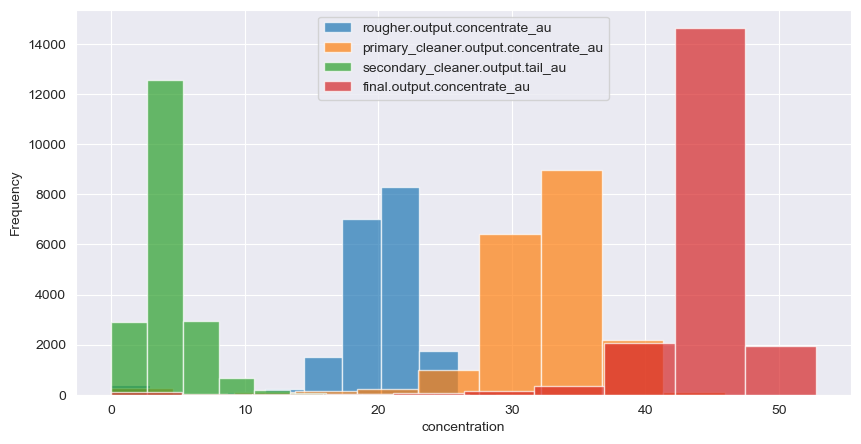

In [25]:
au = ['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'secondary_cleaner.output.tail_au','final.output.concentrate_au']
plot_stages(full, au)

We can see that gold concentration is increasing at the end comparing to before floatation process

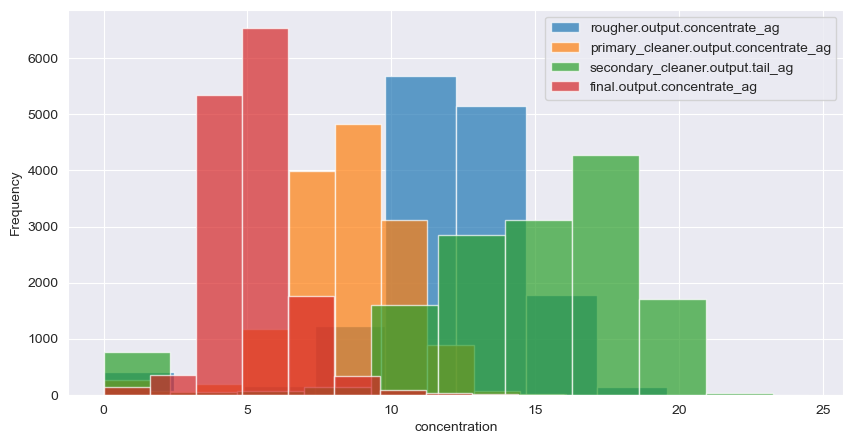

In [26]:
ag = ['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'secondary_cleaner.output.tail_ag','final.output.concentrate_ag']
plot_stages(train, ag)

Silver concentration is lower comparing to flotation process

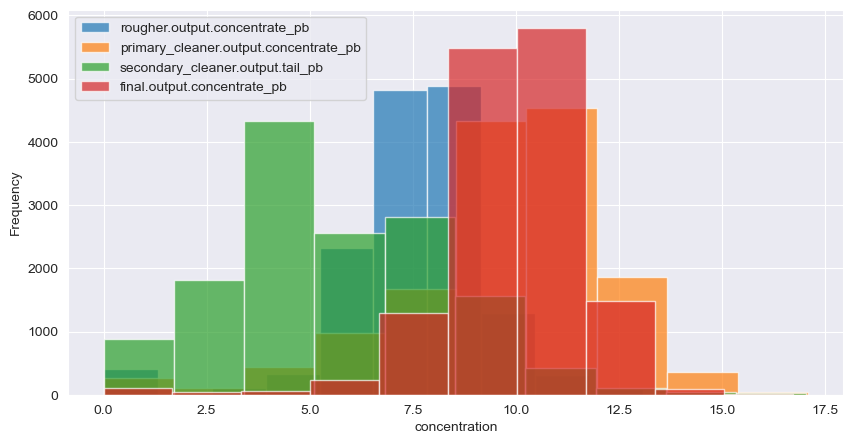

In [27]:
pb = ['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'secondary_cleaner.output.tail_pb','final.output.concentrate_pb']
plot_stages(train, pb)

Here we can see that final output of PB element is higher then on floataion process

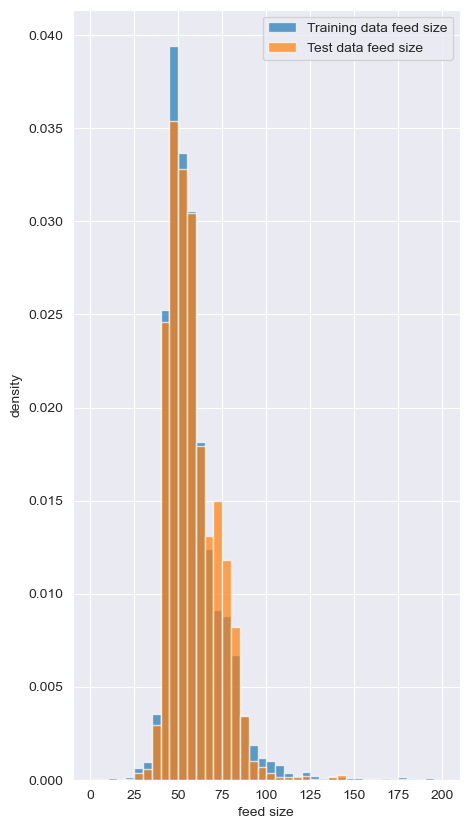

Train feed size mean: 59.07086496192802
Train feed size median: 54.46425905050413
Test feed size mean: 59.13615007330832
Test feed size median: 55.46105787765386


In [28]:
train['rougher.input.feed_size'].hist(alpha=.7, label="Training data feed size", bins=40, figsize=(5,10), range=(0,200), density=True)
test['rougher.input.feed_size'].hist(alpha=.7,label="Test data feed size", bins=40,range=(0,200), density=True)
plt.legend()
plt.xlabel("feed size")
plt.ylabel("density")
plt.show()

print("Train feed size mean: {}\nTrain feed size median: {}".format(train['rougher.input.feed_size'].mean(),train['rougher.input.feed_size'].median()))
print("Test feed size mean: {}\nTest feed size median: {}".format(test['rougher.input.feed_size'].mean(),test['rougher.input.feed_size'].median()))

Distribution between train data and test data about the same so evaluation of model would be correct

<AxesSubplot:>

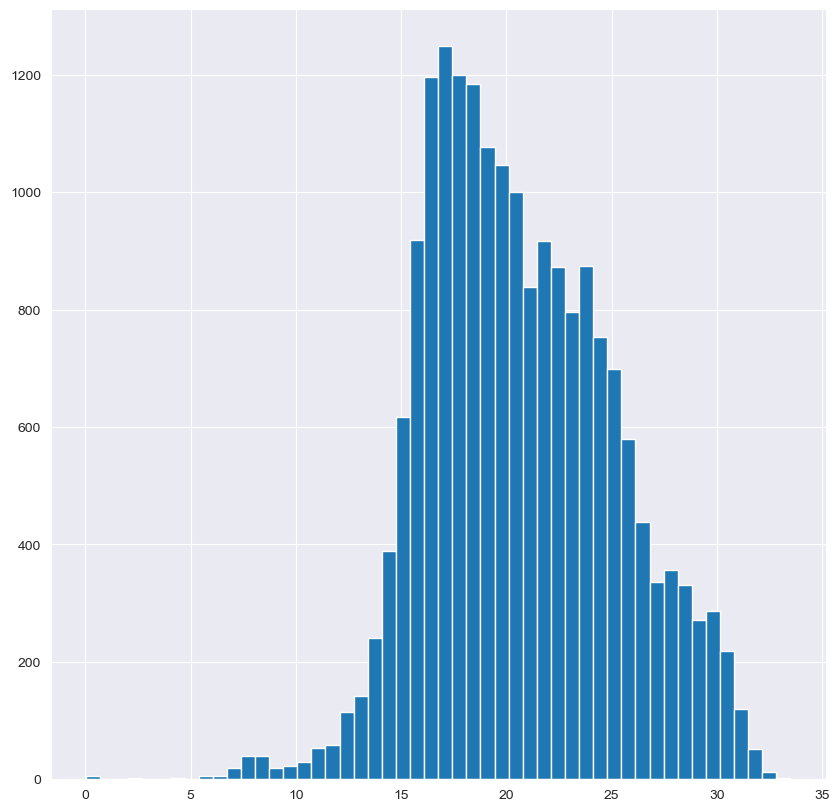

In [29]:
full['total_mixture'] = full[[
    'rougher.input.feed_ag','rougher.input.feed_pb',
    'rougher.input.feed_au']].sum(axis = 1, skipna = True)

full['total_mixture'].hist(bins=50, figsize=(10,10))

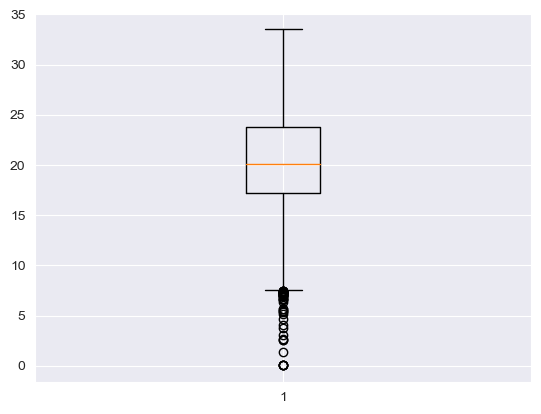

In [89]:
plt.boxplot(full['total_mixture'])
plt.show()

<AxesSubplot:>

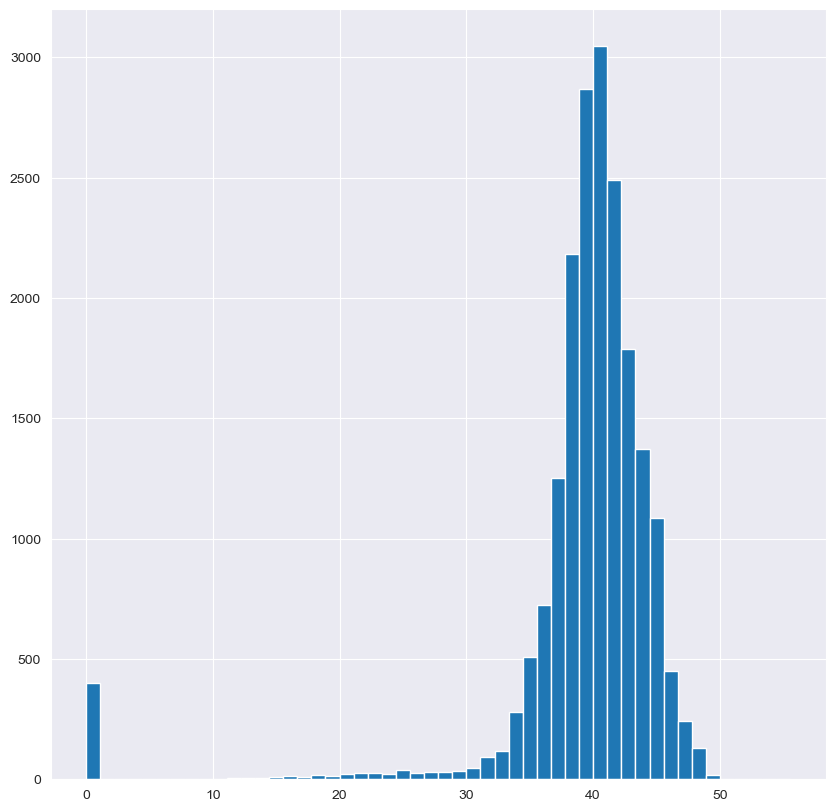

In [90]:
full['total_rougher_output'] = full[[
    'rougher.output.concentrate_ag','rougher.output.concentrate_pb',
    'rougher.output.concentrate_au']].sum(axis = 1, skipna= True)
full['total_rougher_output'].hist(bins=50, figsize=(10,10))

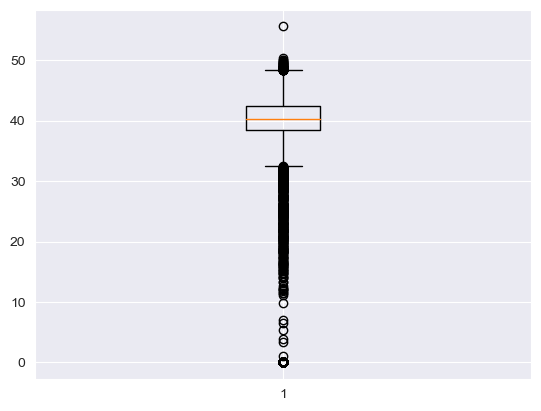

In [91]:
plt.boxplot(full['total_rougher_output'])
plt.show()

<AxesSubplot:>

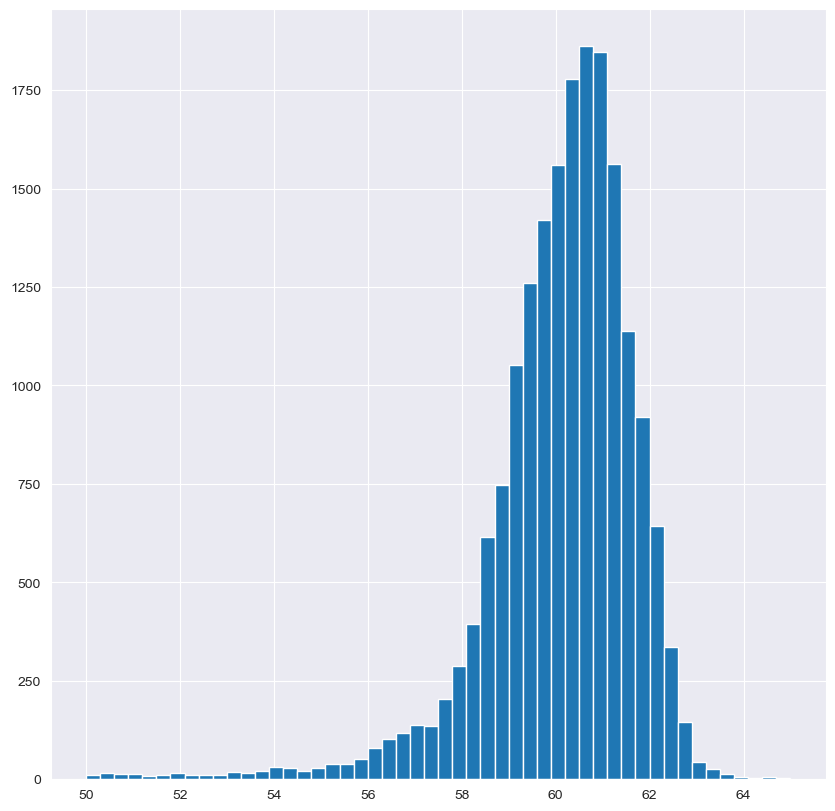

In [92]:
full['total_final_output'] = full[[
    'final.output.concentrate_ag','final.output.concentrate_pb',
    'final.output.concentrate_au']].sum(axis = 1, skipna = True)

full['total_final_output'].hist(bins=50, figsize=(10,10), range=(50,65))

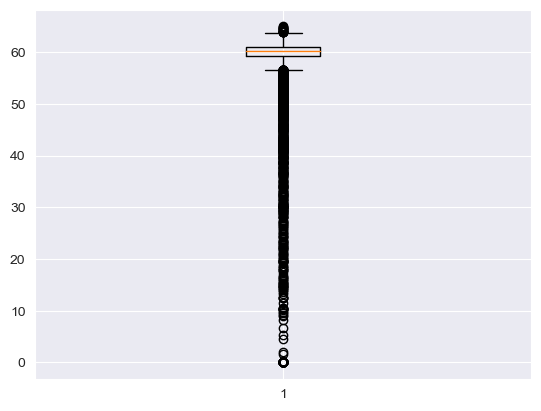

In [93]:
plt.boxplot(full['total_final_output'])
plt.show()

As we can we on each step the concentration of elements are increasing. And also our outliners are increasing as well

In [94]:
# returns data without outliers that less then 1
def delete_rows(data, column1, column2, column3):

    row_sums = data[[column1, column2, column3]].sum(axis=1)
    df = data[row_sums > 1]
    return df

In [95]:
train = delete_rows(train,'rougher.input.feed_ag','rougher.input.feed_pb','rougher.input.feed_au')
train = delete_rows(train,'rougher.output.concentrate_ag','rougher.output.concentrate_pb','rougher.output.concentrate_au')
train = delete_rows(train,'final.output.concentrate_ag','final.output.concentrate_pb','final.output.concentrate_au')

In [96]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14085 entries, 2016-01-15 00:00:00 to 2017-12-09 13:59:59
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.input.feed_au                               14085 non-null  float64
 1   rougher.input.feed_ag                               14085 non-null  float64
 2   rougher.input.feed_pb                               14085 non-null  float64
 3   rougher.input.feed_sol                              14085 non-null  float64
 4   rougher.input.feed_rate                             14085 non-null  float64
 5   rougher.input.feed_size                             14085 non-null  float64
 6   rougher.input.floatbank10_sulfate                   14085 non-null  float64
 7   rougher.input.floatbank10_xanthate                  14085 non-null  float64
 8   rougher.state.floatbank10_a_air          

In [97]:
#Choosing columns that are both in train and test data
train = train[train.columns.intersection(list_of_columns_in_test)]
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14085 entries, 2016-01-15 00:00:00 to 2017-12-09 13:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_au                       14085 non-null  float64
 1   rougher.input.feed_ag                       14085 non-null  float64
 2   rougher.input.feed_pb                       14085 non-null  float64
 3   rougher.input.feed_sol                      14085 non-null  float64
 4   rougher.input.feed_rate                     14085 non-null  float64
 5   rougher.input.feed_size                     14085 non-null  float64
 6   rougher.input.floatbank10_sulfate           14085 non-null  float64
 7   rougher.input.floatbank10_xanthate          14085 non-null  float64
 8   rougher.state.floatbank10_a_air             14085 non-null  float64
 9   rougher.state.floatbank10_a_level           1408

In [98]:
train.isna().sum()

rougher.input.feed_au                         0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_sol                        0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.state.floatbank10_a_air               0
rougher.state.floatbank10_a_level             0
rougher.state.floatbank10_b_air               0
rougher.state.floatbank10_b_level             0
rougher.state.floatbank10_c_air               0
rougher.state.floatbank10_c_level             0
rougher.state.floatbank10_d_air               0
rougher.state.floatbank10_d_level             0
rougher.state.floatbank10_e_air               0
rougher.state.floatbank10_e_level             0
rougher.state.floatbank10_f_air               0
rougher.state.floatbank10_f_level             0
rougher.input.floatbank11_sulfate       

In [99]:
train = train.dropna()
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14085 entries, 2016-01-15 00:00:00 to 2017-12-09 13:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_au                       14085 non-null  float64
 1   rougher.input.feed_ag                       14085 non-null  float64
 2   rougher.input.feed_pb                       14085 non-null  float64
 3   rougher.input.feed_sol                      14085 non-null  float64
 4   rougher.input.feed_rate                     14085 non-null  float64
 5   rougher.input.feed_size                     14085 non-null  float64
 6   rougher.input.floatbank10_sulfate           14085 non-null  float64
 7   rougher.input.floatbank10_xanthate          14085 non-null  float64
 8   rougher.state.floatbank10_a_air             14085 non-null  float64
 9   rougher.state.floatbank10_a_level           1408

In [100]:
#adding our targets to our train and test data from full data
train = train.merge(full[['rougher.output.recovery', 'final.output.recovery']], on='date', how='inner')
test = test.merge(full[['rougher.output.recovery', 'final.output.recovery']], on='date', how='inner')

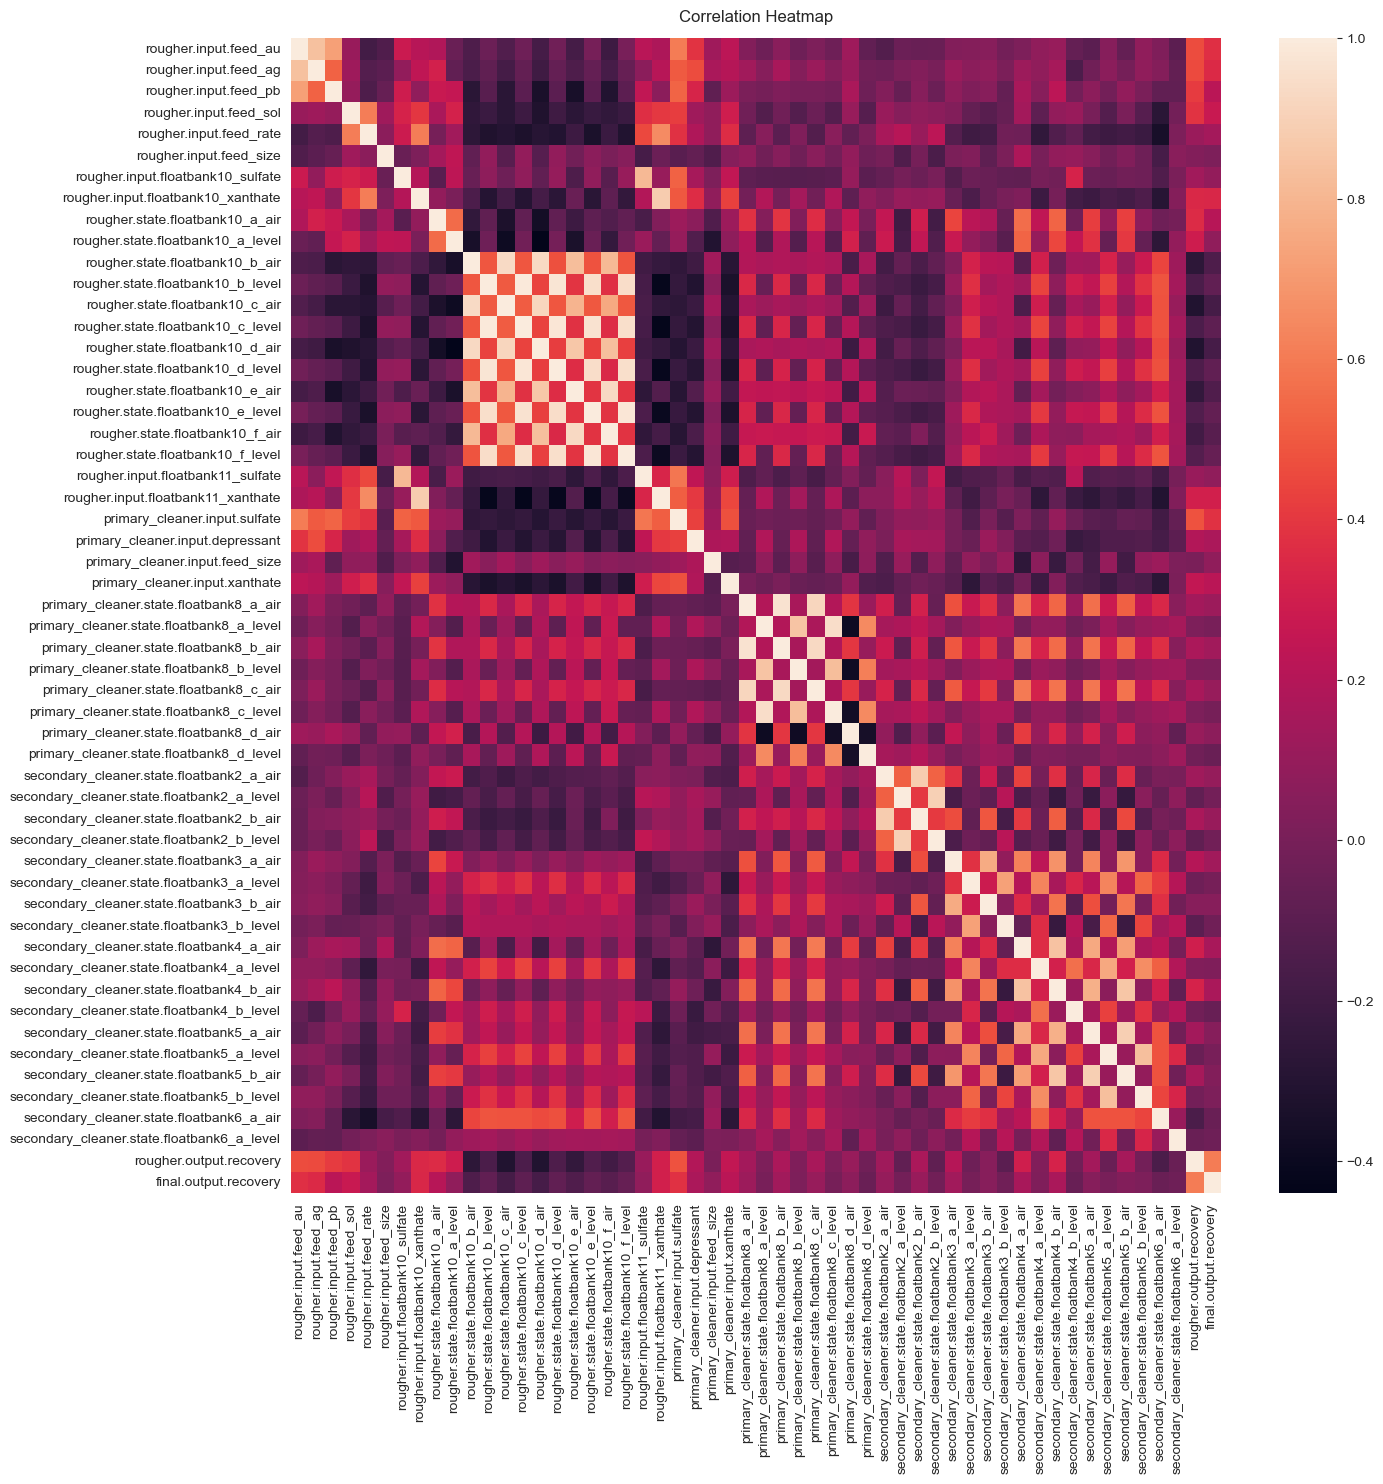

In [101]:
#check heatmap corr
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(train.corr())
heatmap.set_title('Correlation Heatmap', pad=12);

From our heat map i suggest we leave only
    rougher.input.feed
    rougher.input.floatbank10_sulfate
    rougher.input.floatbank10_xanthate
    rougher.state.floatbankl10_a_air
    rougher.state.floatbankl10_a_level
    primary_cleaner.input
    primary_cleaner.state.floatbank8_a_air
    primary_cleaner.state.floatbank8_a_level
    secondary_cleaner.state.floatbank2_a_air
    secondary_cleaner.state.floatbank2_a_level
    rougher.output.recovery
    final.output.recovery

We do that to avoid  overfitting

In [102]:
list_to_keep = ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol',
                'rougher.input.feed_rate', 'rougher.input.feed_size', 'rougher.input.floatbank10_sulfate',
                'rougher.input.floatbank10_xanthate',
                'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level', 'primary_cleaner.input.sulfate',
                'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
                'primary_cleaner.state.floatbank8_a_air', 'primary_cleaner.state.floatbank8_a_level',
                'secondary_cleaner.state.floatbank2_a_air', 'secondary_cleaner.state.floatbank2_a_level',
                'rougher.output.recovery', 'final.output.recovery']
train = train[list_to_keep]
test = test[list_to_keep]

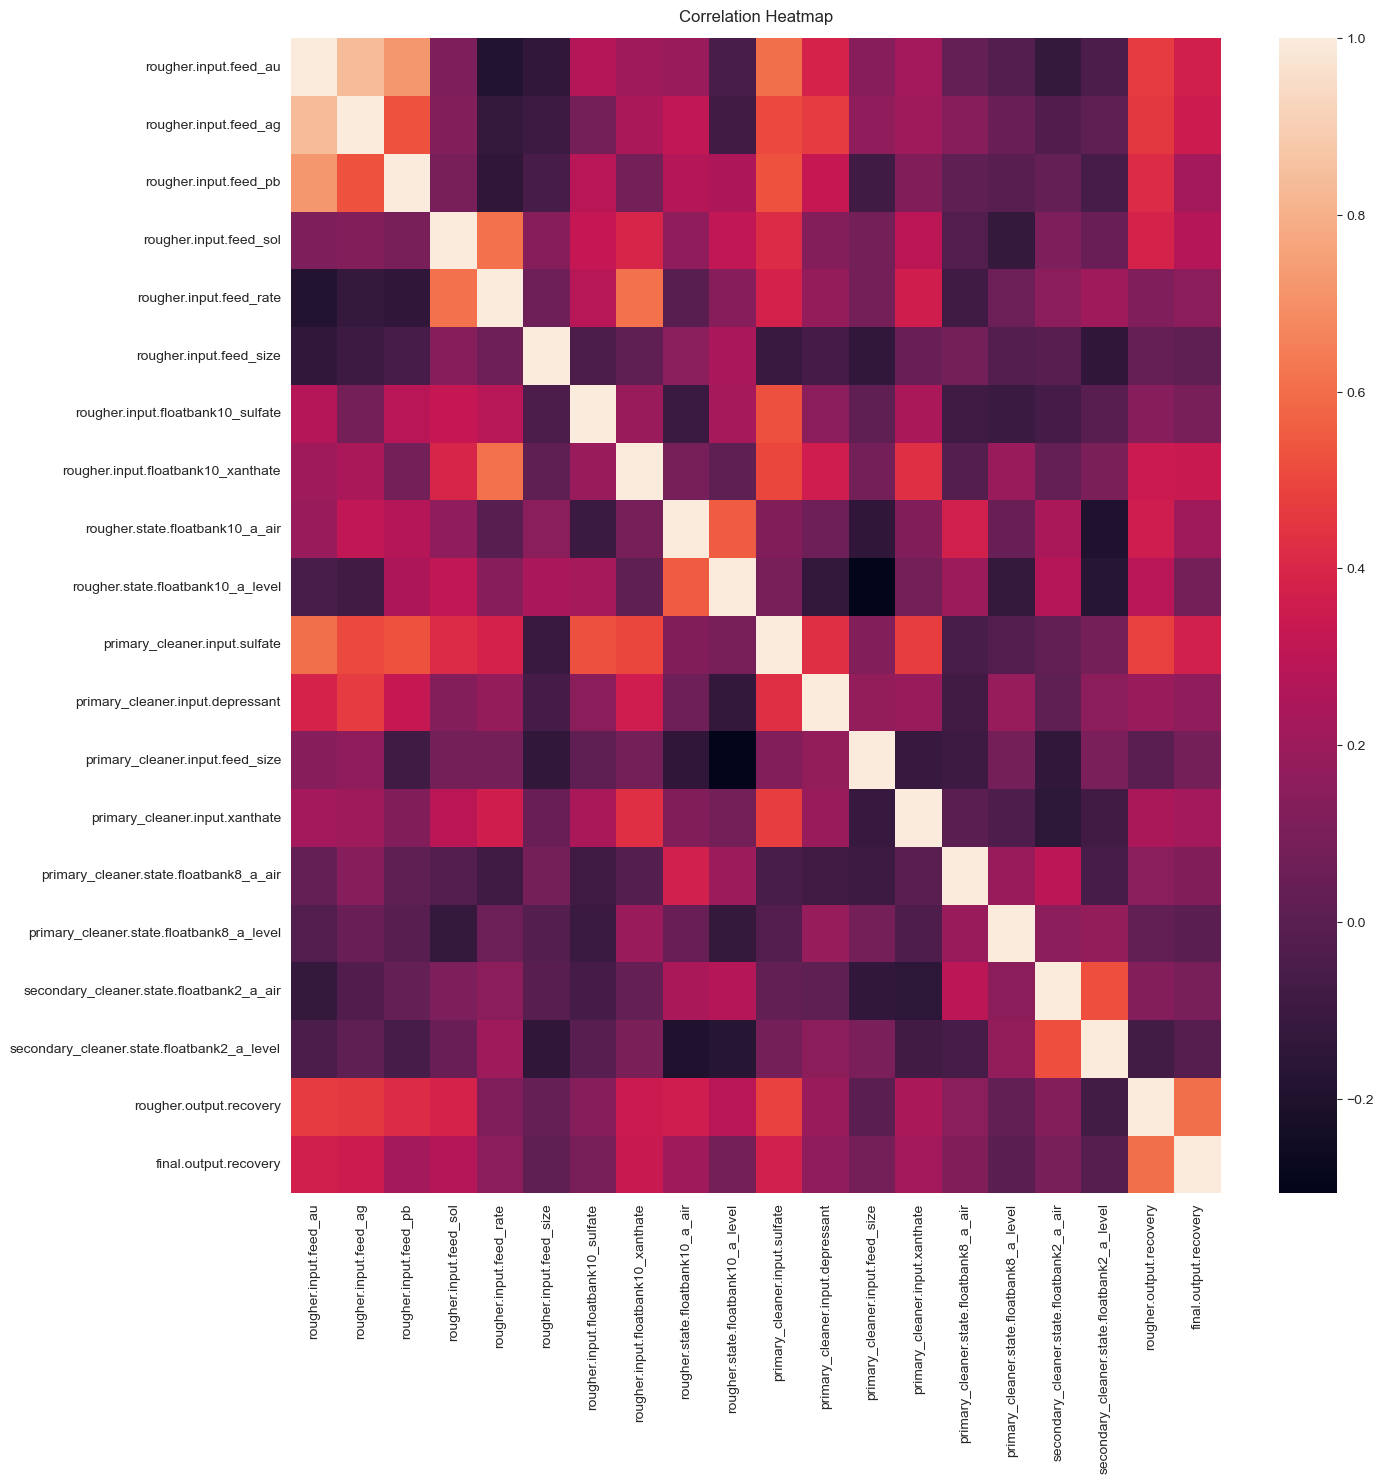

In [103]:
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(train.corr())
heatmap.set_title('Correlation Heatmap', pad=12);

## sMAPE, Final MAPE and a model

In [104]:
#split data for training model
features_train = train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train_r = train['rougher.output.recovery']
target_train_f = train['final.output.recovery']
features_test = test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test_r = test['rougher.output.recovery']
target_test_f = test['final.output.recovery']

In [105]:
def smape(y_true, y_pred):

    smape_count = 0
    for i in range(len(y_true)):
        smape_count += abs(y_true[i] - y_pred[i]) / ((abs(y_true[i]) + abs(y_pred[i])) / 2)
    return smape_count / len(y_true) * 100

In [106]:
def final_smape(y_pred_rougher, y_true_rougher, y_pred_final, y_true_final):
    return 0.25 * smape(y_pred=y_pred_rougher, y_true=y_true_rougher) + 0.75 * smape(y_pred=y_pred_final, y_true=y_true_final)

smape_score = make_scorer(smape)

In [107]:
#collect features names to rename after scaling
features_names = features_train.columns

In [108]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)
features_train_scaled = pd.DataFrame(features_train_scaled, columns=features_names)
features_test_scaled = pd.DataFrame(features_test_scaled, columns=features_names)

In [109]:
linear_model = LinearRegression()
linear_model_train_r_smape = cross_validate(linear_model,features_train_scaled,target_train_r, scoring=smape_score, cv=5)
linear_model_train_f_smape = cross_validate(linear_model,features_train_scaled,target_train_f, scoring=smape_score, cv=5)

final_score = (linear_model_train_r_smape['test_score'] + linear_model_train_f_smape['test_score'])/2
print("Average sMAPE score for LinearRegression Model: ", final_score.mean())

Average sMAPE score for LinearRegression Model:  7.742631968074669


In [111]:
for depth in range(1,10):
    decision_tree_model = DecisionTreeRegressor(random_state=42, max_depth=depth)

    decision_tree_model_train_r_smape = cross_validate(decision_tree_model,features_train,target_train_r.to_numpy(), scoring=smape_score, cv=5)
    decision_tree_model_train_f_smape = cross_validate(decision_tree_model,features_train,target_train_f.to_numpy(), scoring=smape_score, cv=5)

    final_score = np.nan_to_num((decision_tree_model_train_r_smape['test_score'] + decision_tree_model_train_f_smape['test_score'])/2) #wrap in in nan_to_num to avoid division on 0 or Nans
    print("Average sMAPE score with max depth of {}: {}".format(depth, final_score.mean()))

Average sMAPE score with max depth of 1: 8.304805364203323
Average sMAPE score with max depth of 2: 7.849004759658365
Average sMAPE score with max depth of 3: 8.096302012666758
Average sMAPE score with max depth of 4: 8.094683159981347
Average sMAPE score with max depth of 5: 8.412564195715952
Average sMAPE score with max depth of 6: 8.754282283047694
Average sMAPE score with max depth of 7: 9.175737989061968
Average sMAPE score with max depth of 8: 9.9094356462452
Average sMAPE score with max depth of 9: 9.958254655908771


In [112]:
random_forest_model = RandomForestRegressor(random_state=42, n_estimators=20, max_depth=5, min_samples_leaf=25, min_samples_split=2)

random_forest_train_r_smape = cross_validate(random_forest_model,features_train,target_train_r, scoring=smape_score, cv=5)
random_forest_train_f_smape = cross_validate(random_forest_model,features_train,target_train_r, scoring=smape_score, cv=5)

final_score = np.nan_to_num((random_forest_train_r_smape['test_score'] + random_forest_train_r_smape['test_score'])/2)
print("Average sMAPE score: ", final_score.mean())

Average sMAPE score:  6.618444723450021


Random Forest Regression  was the best model with n_estimators=20, max_depth=5, min_samples_leaf=25, min_samples_split=2, so lets do the final test and count final sMAPE

In [113]:
random_forest_model_final = RandomForestRegressor(random_state=42, n_estimators=20, max_depth=5, min_samples_leaf=25, min_samples_split=2)
random_forest_model_final.fit(features_train, target_train_r)
predicted_r = random_forest_model_final.predict(features_test)
random_forest_model_final.fit(features_train, target_train_f)
predicted_f = random_forest_model_final.predict(features_test)

In [114]:
final_value = final_smape(predicted_r,target_test_r,predicted_f,target_test_f)
print(f'Final sMAPE of our model on test data {(final_value/100):.2%}')

Final sMAPE of our model on test data 6.73%


In [115]:
dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(features_train,target_train_r)
dummy_predicted_r = dummy_reg.predict(features_test)
dummy_reg.fit(features_train,target_train_f)
dummy_predicted_f = dummy_reg.predict(features_test)

In [116]:
final_value = final_smape(dummy_predicted_r,target_test_r,dummy_predicted_f,target_test_f)
print(f'Final sMAPE of our Dummy model on test data {(final_value/100):.2%}')

Final sMAPE of our Dummy model on test data 8.47%


### Conclusion

As a result of training and testing models on the training dataset using cross-validation, the best sMAPE (Symmetric Mean Absolute Percentage Error) value for predicting flotation recovery efficiency and final recovery efficiency was achieved using the random forest model. Linear regression and decision tree models were also tested. The average sMAPE values obtained through 5-fold cross-validation were:

For Linear Model: 7.74%
For DecisionTree Model: 7.84%
For RandomForest Model : 6.61%

Best Model: RandomForest Model with final sMAPE = 6.73%

The performance of the Best model was compared to a constant model (the mean of the training data). The constant model performed slightly worse by ~ 1.75%. This small difference from the constant models in this case indicates not poor model quality but rather a high predictability of the data, as both the trained models and constant models achieved relatively good sMAPE values.